In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.CrossEntropyLoss()

In [3]:
images = torch.tensor(np.load("images.npy"), dtype=torch.float32)
labels = torch.tensor(np.load("labels.npy"), dtype=torch.long) - 1

In [57]:
class Model(nn.Module):
	def __init__(self):
		super().__init__()
		self.layers = nn.Sequential(
			nn.Conv2d(3, 32, 5, stride=5),
			nn.ReLU(),
			nn.Conv2d(32, 64, 3, stride=3),
			nn.ReLU(),
			nn.Conv2d(64, 256, 3, stride=3),
			nn.ReLU(),
			nn.Flatten(),
			nn.Linear(4096, 4)
		)
	def forward(self, x):
		return self.layers(x)

In [58]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(5, 5))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    (3): ReLU()
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(3, 3))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=4, bias=True)
  )
)

In [59]:
losses = []

In [60]:
n_epochs = 10
batch_size = 8

for epoch in range(n_epochs):
	permutation = torch.randperm(images.shape[0])
	for i in range(0, permutation.shape[0], batch_size):
		optimizer.zero_grad()

		indices = permutation[i:i+batch_size]
		x, y = images[indices], labels[indices]

		x = x.to(device)
		y = y.to(device)

		logits = model(x.permute(0, 3, 1, 2))
		loss = loss_function(logits, y)
		losses.append(loss.item())
		
		loss.backward()
		optimizer.step()
		

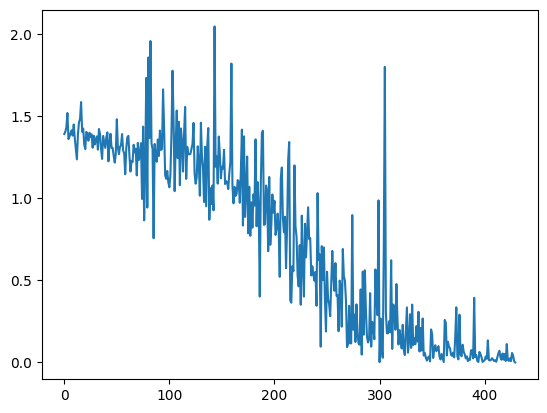

In [61]:
plt.plot(losses)

In [62]:
import csv
files = os.listdir("test")
model.eval()
test_set = torch.tensor(np.load("test_set.npy"), dtype=torch.float32)
predictions = []
for i in range(test_set.shape[0]):
    t = test_set[i:i+1].to(device)
    l = model(t.permute(0, 3, 1, 2))
    predictions.append(torch.argmax(torch.softmax(l, dim=1)).item()+1)
print(len(predictions))
print(len(files))
dictionary = []
for i in range(len(files)):
    dictionary.append([files[i], predictions[i]])
with open("answers.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dictionary)

[[0.006104608532041311, 0.9845566749572754, 0.0003381817659828812, 0.009000524878501892]]
[[0.38212448358535767, 0.008282821625471115, 0.46228036284446716, 0.14731234312057495]]
[[0.0015555949648842216, 0.8013021945953369, 0.13646534085273743, 0.06067689508199692]]
[[0.3342193067073822, 0.65731281042099, 0.006929001305252314, 0.0015388934407383204]]
[[0.6295287609100342, 0.23474392294883728, 0.011719447560608387, 0.12400788813829422]]
[[0.0010009410325437784, 0.012653985992074013, 0.9842766523361206, 0.002068344969302416]]
[[3.526559339661617e-06, 0.0003175531164743006, 0.9887384176254272, 0.010940526612102985]]
[[0.005853902082890272, 0.000493865052703768, 0.12753735482692719, 0.8661149144172668]]
[[0.00031688541639596224, 0.9604681730270386, 0.036579884588718414, 0.0026350754778832197]]
[[0.9716649651527405, 0.012312861159443855, 0.0008249496459029615, 0.0151972072198987]]
[[0.10564232617616653, 0.10694190114736557, 0.7873934507369995, 2.2274696675594896e-05]]
[[0.0001636827946640551